Для выполнения этого задания у нас уже залиты таблички в БД (мы это сделали в ДЗ2, оно лежит выполеннное в том же репозитории). Так же, мы уже создали таблицу product_cor, в которой уникальный product_id. Воспользуемся этими таблицами для выполнения ДЗ3.

### Запрос 1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества

```
# SELECT
    job_industry_category,
    COUNT(*) as client_count
FROM customer
GROUP BY job_industry_category
ORDER BY client_count DESC;
```



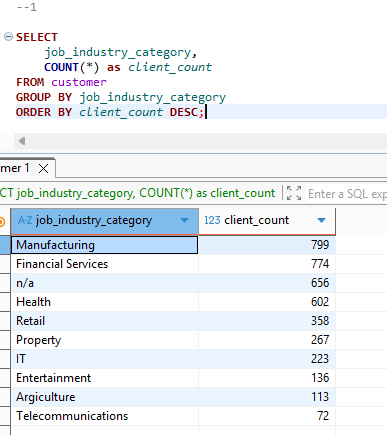

### Запрос 2. Найти общую сумму дохода (list_price*quantity) по всем подтвержденным заказам за каждый месяц по сферам деятельности клиентов. Отсортировать по году, месяцу и сфере деятельности



```
SELECT
    EXTRACT(YEAR FROM o.order_date) as year,
    EXTRACT(MONTH FROM o.order_date) as month,
    c.job_industry_category,
    SUM(oi.item_list_price_at_sale * oi.quantity) as total_income
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN customer c ON o.customer_id = c.customer_id
WHERE o.order_status = 'Approved'
GROUP BY year, month, c.job_industry_category
ORDER BY year, month, c.job_industry_category;
```



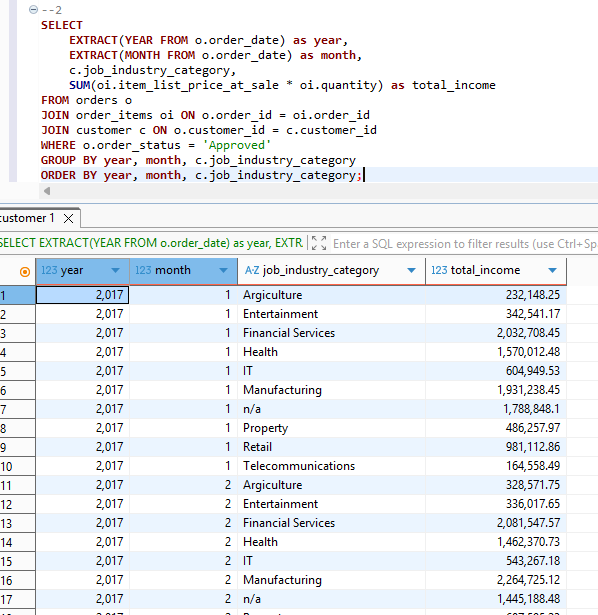

### Запрос 3. Вывести количество уникальных онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT. Включить бренды, у которых нет онлайн-заказов от IT-клиентов, с количеством 0



```
SELECT
    p.brand,
    COUNT(DISTINCT CASE WHEN c.job_industry_category = 'IT' THEN o.order_id END) as it_online_orders
FROM product_cor p
LEFT JOIN order_items oi ON p.product_id = oi.product_id
LEFT JOIN orders o ON oi.order_id = o.order_id AND o.online_order = true AND o.order_status = 'Approved'
LEFT JOIN customer c ON o.customer_id = c.customer_id
GROUP BY p.brand
ORDER BY it_online_orders DESC;

```



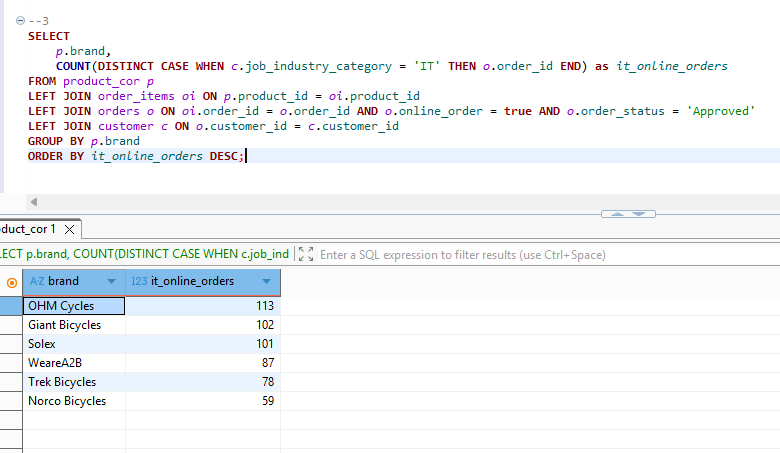

### Запрос 4. Найти по всем клиентам: сумму всех заказов (общего дохода), максимум, минимум и количество заказов, а также среднюю сумму заказа по каждому клиенту. Отсортировать результат по убыванию суммы всех заказов и количества заказов. Выполнить двумя способами: используя только GROUP BY и используя только оконные функции. Сравнить результат

если посчитать через GROUP BY:


```
SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(oi.item_list_price_at_sale * oi.quantity) as total_income,
    MAX(oi.item_list_price_at_sale * oi.quantity) as max_order,
    MIN(oi.item_list_price_at_sale * oi.quantity) as min_order,
    COUNT(o.order_id) as order_count,
    AVG(oi.item_list_price_at_sale * oi.quantity) as avg_order
FROM customer c
LEFT JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY total_income DESC NULLS LAST, order_count DESC;
```



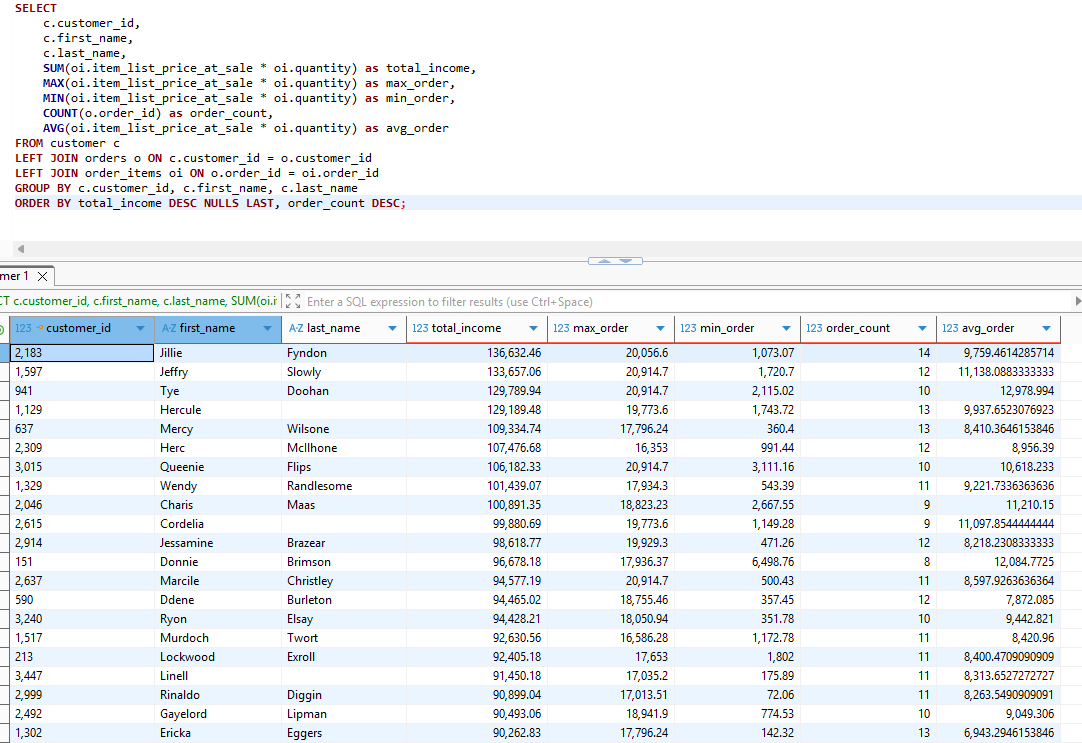

Если посчитать оконной функцией:


```
SELECT DISTINCT
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(oi.item_list_price_at_sale * oi.quantity) OVER (PARTITION BY c.customer_id) as total_income,
    MAX(oi.item_list_price_at_sale * oi.quantity) OVER (PARTITION BY c.customer_id) as max_order,
    MIN(oi.item_list_price_at_sale * oi.quantity) OVER (PARTITION BY c.customer_id) as min_order,
    COUNT(o.order_id) OVER (PARTITION BY c.customer_id) as order_count,
    AVG(oi.item_list_price_at_sale * oi.quantity) OVER (PARTITION BY c.customer_id) as avg_order
FROM customer c
LEFT JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
ORDER BY total_income DESC NULLS LAST, order_count DESC; --исключаем пустые строчки, чтобы видеть не null
```



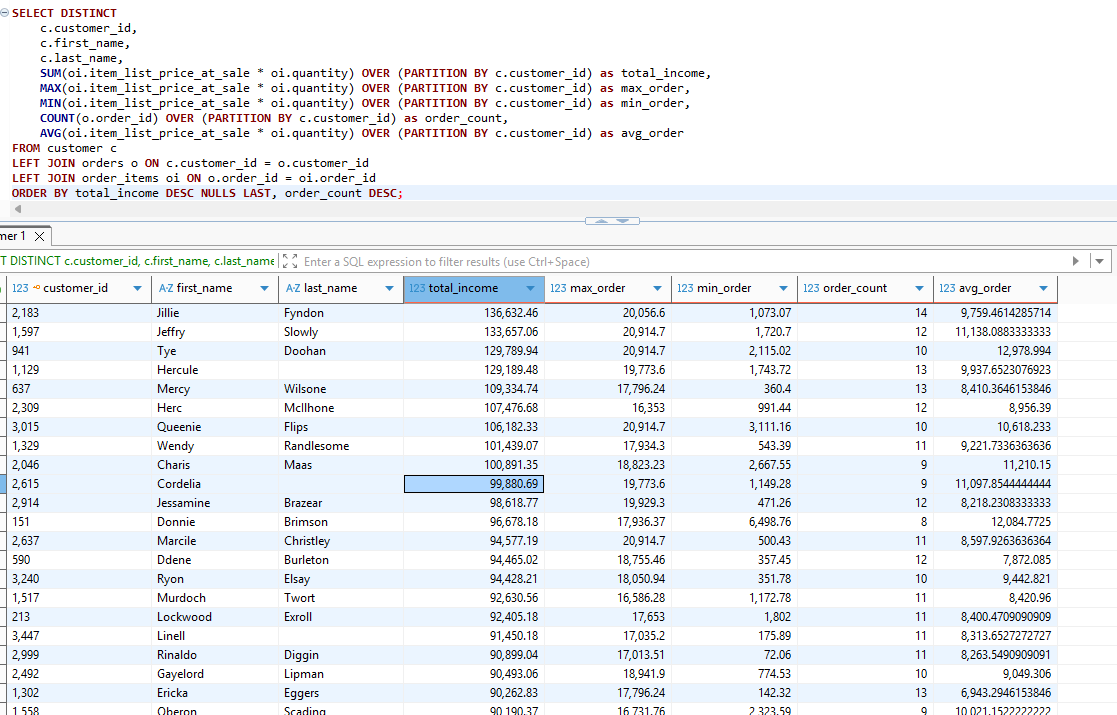

Вывод: Разницы не видно или она незначительна

### Запрос 5. Найти имена и фамилии клиентов с топ-3 минимальной и топ-3 максимальной суммой транзакций за весь период (учесть клиентов, у которых нет заказов)



```
WITH customer_totals AS (
    SELECT
        c.customer_id,
        c.first_name,
        c.last_name,
        COALESCE(SUM(oi.item_list_price_at_sale * oi.quantity), 0) as total_spent
    FROM customer c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    LEFT JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.first_name, c.last_name
),
min_max AS (
    (SELECT *, 'min' as type FROM customer_totals ORDER BY total_spent LIMIT 3)
    UNION ALL
    (SELECT *, 'max' as type FROM customer_totals ORDER BY total_spent DESC LIMIT 3)
)
SELECT * FROM min_max ORDER BY type, total_spent;
```



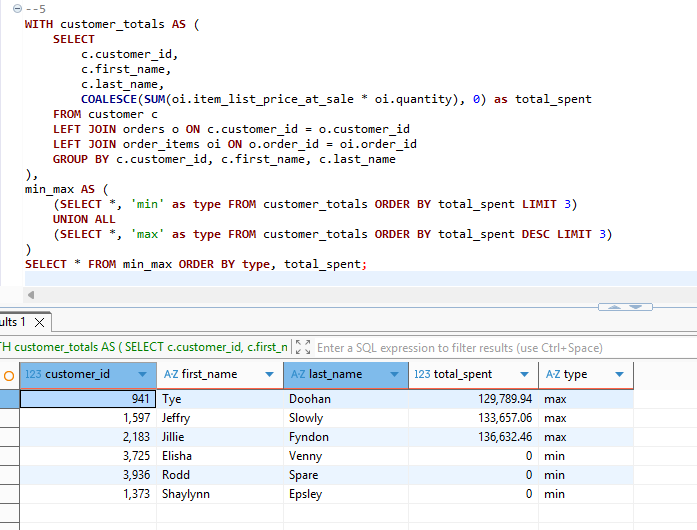

### Запрос 6. Вывести только вторые транзакции клиентов (если они есть). Решить с помощью оконных функций. Если у клиента меньше двух транзакций, он не должен попасть в результат



```
WITH numbered_orders AS (
    SELECT
        o.customer_id,
        o.order_id,
        o.order_date,
        ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY o.order_date) as order_num
    FROM orders o
)
SELECT
    c.first_name,
    c.last_name,
    no.order_id,
    no.order_date
FROM numbered_orders no
JOIN customer c ON no.customer_id = c.customer_id
WHERE no.order_num = 2;
```



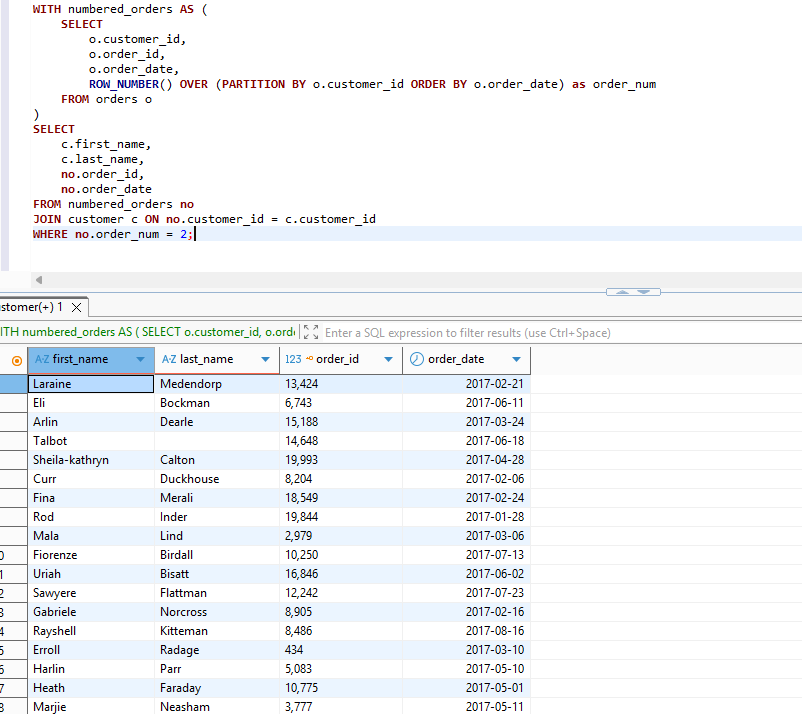

### Запрос 7. Вывести имена, фамилии и профессии клиентов, а также длительность максимального интервала (в днях) между двумя последовательными заказами. Исключить клиентов, у которых только один или меньше заказов



```
WITH order_intervals AS (
    SELECT
        o.customer_id,
        o.order_date,
        LEAD(o.order_date) OVER (PARTITION BY o.customer_id ORDER BY o.order_date) as next_order_date,
        LEAD(o.order_date) OVER (PARTITION BY o.customer_id ORDER BY o.order_date) - o.order_date as days_between
    FROM orders o
),
max_intervals AS (
    SELECT
        customer_id,
        MAX(days_between) as max_interval_days
    FROM order_intervals
    WHERE days_between IS NOT NULL
    GROUP BY customer_id
    HAVING COUNT(*) >= 1  
)
SELECT
    c.first_name,
    c.last_name,
    c.job_title,
    mi.max_interval_days
FROM max_intervals mi
JOIN customer c ON mi.customer_id = c.customer_id
ORDER BY mi.max_interval_days DESC;
```



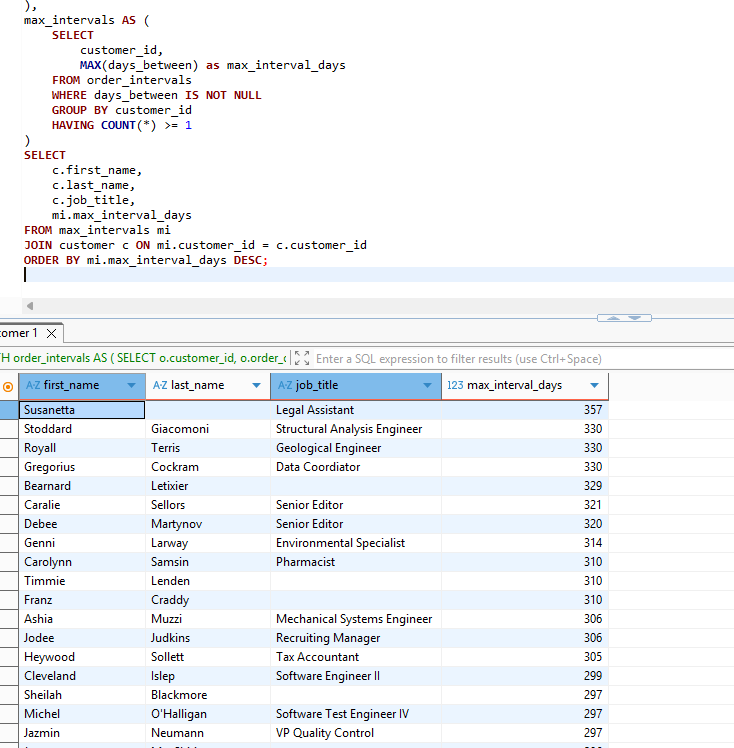

### Запрос 8. Найти топ-5 клиентов (по общему доходу) в каждом сегменте благосостояния (wealth_segment). Вывести имя, фамилию, сегмент и общий доход. Если в сегменте менее 5 клиентов, вывести всех



```
WITH customer_income AS (
    SELECT
        c.customer_id,
        c.first_name,
        c.last_name,
        c.wealth_segment,
        COALESCE(SUM(oi.item_list_price_at_sale * oi.quantity), 0) as total_income,
        ROW_NUMBER() OVER (PARTITION BY c.wealth_segment ORDER BY COALESCE(SUM(oi.item_list_price_at_sale * oi.quantity), 0) DESC) as rank
    FROM customer c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    LEFT JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.first_name, c.last_name, c.wealth_segment
)
SELECT
    first_name,
    last_name,
    wealth_segment,
    total_income
FROM customer_income
WHERE rank <= 5
ORDER BY wealth_segment, rank;
```



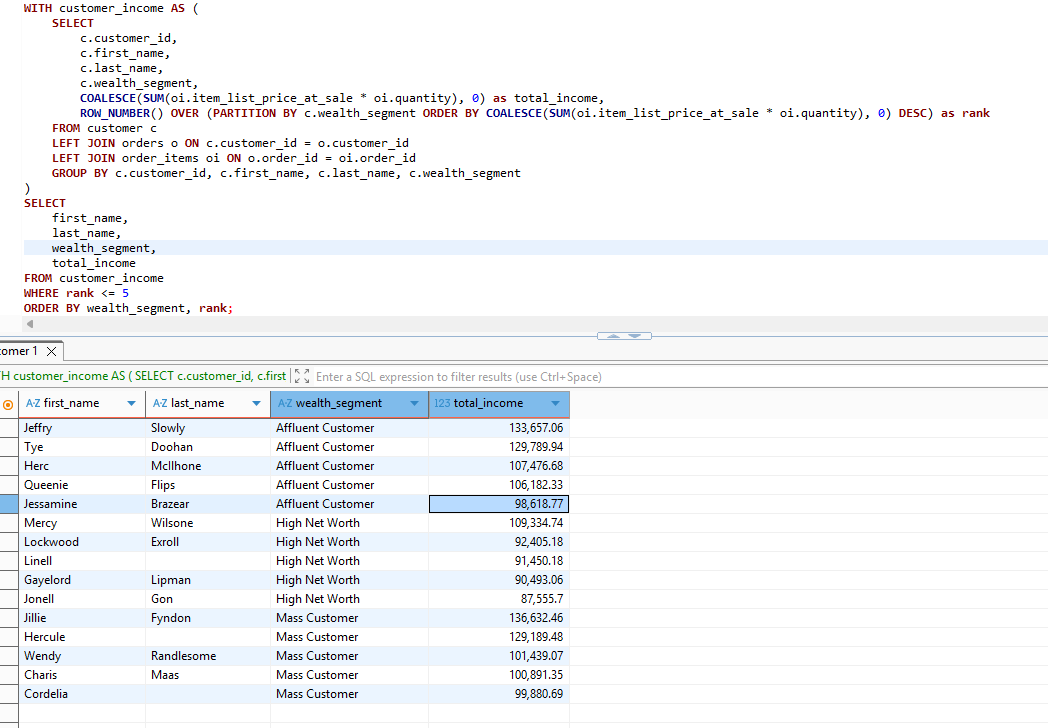